# Statistical Inference Results

### PREPROCESSING

In [1]:
!pip install matplotlib==3.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.2.5
    Uninstalling pyparsing-3.2.5:
      Successfully uninstalled pyparsing-3.2.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

import scipy.sparse as sp, warnings
from sklearn.model_selection import ( 
    train_test_split, StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, average_precision_score, classification_report, confusion_matrix
)

In [3]:
df = pd.read_csv("Crime.csv")
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,7800 BEEMAN AV,NaN,34.2124,-118.4092
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,NaN,NaN,NaN,ATOLL AV,N GAULT,34.1993,-118.4203
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,14600 SYLVAN ST,NaN,34.1847,-118.4509
3,210704711,12/24/2020 12:00:00 AM,12/24/2020 12:00:00 AM,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331.0,NaN,NaN,NaN,6000 COMEY AV,NaN,34.0339,-118.3747
4,201418201,10/03/2020 12:00:00 AM,09/29/2020 12:00:00 AM,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,NaN,NaN,NaN,4700 LA VILLA MARINA,NaN,33.9813,-118.4350


In [4]:
df.columns = [c.strip() for c in df.columns]

rename_map = {
    "Date Rptd": "Date_Reported",
    "DATE OCC": "Date_Occurred",
    "TIME OCC": "Time_Occurred",
    "AREA NAME": "Area_Name",
    "Rpt Dist No": "Reported_District_Num",
    "Part 1-2": "Part_1_2",
    "Crm Cd": "Crime_Code",
    "Crm Cd Desc": "Crime_Code_Desc",
    "Mocodes": "Mocodes",
    "Premis Desc": "Premis_Desc",
    "Weapon Desc": "Weapon_Desc",
    "Status Desc": "Status_Desc",
    "Vict Age": "Victim_Age",
    "Vict Sex": "Victim_Sex",
    "Vict Descent": "Victim_Descent",
    "LOCATION": "Location",
    "Cross Street": "Cross_Street",
    "LAT": "Latitude",
    "LON": "Longitude",
    "Crm Cd 1": "Crime_Cd_1",
    "Crm Cd 2": "Crime_Cd_2",
    "Crm Cd 3": "Crime_Cd_3",
    "Crm Cd 4": "Crim_Cd_4",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

In [5]:
if "Date_Occurred" not in df.columns:
    raise KeyError("Expected 'Date_Occurred' column is missing after rename step.")

DATE_FMT = "%m/%d/%Y %I:%M:%S %p"

df["Date_Occurred_str"] = df["Date_Occurred"].astype("string").str.strip()

dt1 = pd.to_datetime(df["Date_Occurred_str"], format=DATE_FMT, errors="coerce")

mask_no_ampm = dt1.isna() & df["Date_Occurred_str"].str.match(
    r"^\d{1,2}/\d{1,2}/\d{2,4}\s+\d{1,2}:\d{2}:\d{2}$", na=False
)
if mask_no_ampm.any():
    dt2 = pd.to_datetime(df.loc[mask_no_ampm, "Date_Occurred_str"] + " AM",
                         format=DATE_FMT, errors="coerce")
    dt1 = dt1.combine_first(dt2)

df["Date_Occurred_dt"] = dt1

df["Occurred_Year"]  = df["Date_Occurred_dt"].dt.year
df["Occurred_Month"] = df["Date_Occurred_dt"].dt.month
df["Occurred_Day"]   = df["Date_Occurred_dt"].dt.day

In [6]:
def split_time_hhmm(series: pd.Series):
    s = series.astype("string").str.strip().str.replace(r"[^0-9]", "", regex=True)
    s = s.replace("", np.nan).str.zfill(4)
    hour = pd.to_numeric(s.str.slice(0, 2), errors="coerce")
    minute = pd.to_numeric(s.str.slice(2, 4), errors="coerce")
    hour = hour.mask((hour < 0) | (hour > 23))
    minute = minute.mask((minute < 0) | (minute > 59))
    return hour, minute

df["Hour"], df["Minute"] = split_time_hhmm(df["Time_Occurred"])


In [7]:
peek_cols = [
    "Date_Occurred", "Date_Occurred_dt", "Occurred_Year", "Occurred_Month", "Occurred_Day",
    "Time_Occurred", "Hour", "Minute",
]
print(df[ [c for c in peek_cols if c in df.columns] ].head(10))

            Date_Occurred Date_Occurred_dt  Occurred_Year  Occurred_Month  \
0  11/07/2020 12:00:00 AM       2020-11-07           2020              11   
1  10/18/2020 12:00:00 AM       2020-10-18           2020              10   
2  10/30/2020 12:00:00 AM       2020-10-30           2020              10   
3  12/24/2020 12:00:00 AM       2020-12-24           2020              12   
4  09/29/2020 12:00:00 AM       2020-09-29           2020               9   
5  11/11/2020 12:00:00 AM       2020-11-11           2020              11   
6  04/16/2020 12:00:00 AM       2020-04-16           2020               4   
7  07/07/2020 12:00:00 AM       2020-07-07           2020               7   
8  03/02/2020 12:00:00 AM       2020-03-02           2020               3   
9  09/01/2020 12:00:00 AM       2020-09-01           2020               9   

   Occurred_Day  Time_Occurred  Hour  Minute  
0             7            845     8      45  
1            18           1845    18      45  
2          

In [8]:
df["DayOfWeek"] = df["Date_Occurred_dt"].dt.day_name()

order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [9]:
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

df["Month_Name"] = df["Occurred_Month"].apply(
    lambda x: month_names[int(x)-1] if pd.notnull(x) and 1 <= int(x) <= 12 else None
)

In [10]:
   base = (
    df.dropna(subset=["Occurred_Year", "Hour"])
      .loc[lambda x: x["Hour"].between(0, 23)]
)

counts_h0 = (
    base.loc[base["Hour"] == 0]
        .groupby("Occurred_Year")
        .size()
        .rename("HOUR_0")
)

counts_h12_raw = (
    base.loc[base["Hour"] == 12]
        .groupby("Occurred_Year")
        .size()
        .rename("HOUR_12_raw")
)

if "Time_Occurred" in df.columns:
    mask_not_1200 = df["Time_Occurred"].astype("string").str.zfill(4) != "1200"
    counts_h12_no1200 = (
        base.loc[(base["Hour"] == 12) & mask_not_1200]
            .groupby("Occurred_Year")
            .size()
            .rename("HOUR_12_no1200")
    )
else:
    counts_h12_no1200 = pd.Series(dtype="int64", name="HOUR_12_no1200")

year_totals = (
    base.groupby("Occurred_Year")
        .size()
        .rename("TOTAL_YEAR")
)

summary = (
    pd.concat([year_totals, counts_h0, counts_h12_raw, counts_h12_no1200], axis=1)
      .fillna(0).astype(int)
      .reset_index()
      .sort_values("Occurred_Year")
)

print("Per-year counts (midnight vs noon):")
print(summary.to_string(index=False))


Per-year counts (midnight vs noon):
 Occurred_Year  TOTAL_YEAR  HOUR_0  HOUR_12_raw  HOUR_12_no1200
          2020      199847    8111        13753            5673
          2021      209876    8248        14278            6558
          2022      235259   10752        17153            8679
          2023      232345    9169        14798            7414
          2024      127567    4187         7824            4284
          2025          97       1            7               5


In [11]:
df["Time_Occurred_str"] = df["Time_Occurred"].astype(str).str.zfill(4)


zero_hour_entries = df[df["Hour"] == 0][["Time_Occurred", "Hour", "Minute"]]

print("Entries where Hour = 0:")
print(zero_hour_entries.head(25).to_string(index=False)) 
print(f"\nTotal entries with HOUR == 0: {len(zero_hour_entries):,}\n")

twelve_hour_entries = df[df["Hour"] == 12][["Time_Occurred", "Hour", "Minute"]]

print("Entries where Hour = 12:")
print(twelve_hour_entries.head(25).to_string(index=False))  # display first 25 neatly
print(f"\nTotal entries with HOUR == 12: {len(twelve_hour_entries):,}\n")

placeholder_mask = df["Time_Occurred_str"] == "1200"
placeholder_entries = df.loc[placeholder_mask, ["Time_Occurred", "Hour", "Minute"]]

print("Entries where Time_Occurred is placeholder (1200):")
print(placeholder_entries.head(25).to_string(index=False))
print(f"\nTotal placeholder entries (Time_Occurred == '1200'): {len(placeholder_entries):,}\n")

if "Occurred_Year" in df.columns:
    placeholder_by_year = (
        df.loc[placeholder_mask]
          .groupby("Occurred_Year")
          .size()
          .reset_index(name="Placeholder_Count")
    )

Entries where Hour = 0:
 Time_Occurred  Hour  Minute
             1     0       1
            30     0      30
             1     0       1
            30     0      30
            10     0      10
             1     0       1
             1     0       1
            40     0      40
            48     0      48
             5     0       5
             1     0       1
             1     0       1
             1     0       1
            45     0      45
             1     0       1
            45     0      45
             1     0       1
             1     0       1
             1     0       1
             1     0       1
             1     0       1
            44     0      44
            20     0      20
            20     0      20
            15     0      15

Total entries with HOUR == 0: 40,468

Entries where Hour = 12:
 Time_Occurred  Hour  Minute
          1240    12      40
          1210    12      10
          1200    12       0
          1200    12       0
          120

In [12]:
placeholder_mask = df["Time_Occurred"].astype(str).str.zfill(4) == "1200"
removed = placeholder_mask.sum()
df = df[~placeholder_mask].copy()

In [13]:
per_year_counts = (
    df.groupby(["Occurred_Year", "Hour"])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=range(24), fill_value=0)
           .sort_index()
)
pd.set_option("display.max_columns", None)  
print(per_year_counts)
pd.reset_option("display.max_columns")
print(per_year_counts.head(30))

Hour              0     1     2     3     4     5     6     7     8     9   \
Occurred_Year                                                                
2020            8111  5819  4968  4316  3607  3368  3969  4743  7093  7112   
2021            8248  6217  5415  4721  3941  3758  4347  5276  7666  7475   
2022           10752  7569  6130  5396  4637  4222  6096  6594  9113  8767   
2023            9169  6785  5837  5098  4316  3909  5585  6005  8611  8494   
2024            4187  3370  2864  2659  2255  2031  3187  3646  4760  4671   
2025               1     1     0     1     1     2     1     3     6     5   

Hour              10     11    12     13     14     15     16     17     18  \
Occurred_Year                                                                 
2020            8343   8400  5673   9062   9899  10772  10828  12114  12298   
2021            9165   9123  6558   9657  10148  10804  11091  12138  12418   
2022           10132  10490  8679  10334  11035  11919  116

In [14]:
def Is_Violent(desc: str) -> bool:
    """Classify a crime description as violent based on keywords."""
    if not isinstance(desc, str):
        return False
    d = desc.upper()
    patterns = [
        # Homicides
        "HOMICIDE", "CRIMINAL HOMICIDE", "MANSLAUGHTER", "MURDER", "LYNCHING",

        # Sex Crimes
        "RAPE", "SEXUAL ASSAULT", "SODOMY", "FORCIBLE RAPE", "ORAL COPULATION",
        "SEXUAL PENETRATION", "BATTERY WITH SEXUAL CONTACT", "LEWD", "INCEST",
        "HUMAN TRAFFICKING", "PANDERING", "PIMPING",

        # Robbery / Theft with Force
        "ROBBERY", "ATTEMPTED ROBBERY", "PURSE SNATCHING", "THEFT FROM PERSON", "BURGLARY",

        # Assault / Battery
        "ASSAULT", "BATTERY", "AGGRAVATED ASSAULT", "BRANDISH WEAPON", 
        "CHILD ABUSE", "INTIMATE PARTNER", "BATTERY POLICE", "BATTERY ON A FIREFIGHTER",

        # Kidnapping / False Imprisonment
        "KIDNAPPING", "FALSE IMPRISONMENT",

        # Weapons / Arson / Shooting
        "SHOOTING", "DISCHARGE FIREARM", "ARSON", "BOMB", "EXPLOSIVE",

        # Threats / Terror / Extortion
        "CRIMINAL THREATS", "EXTORTION", "TERRORIST", "THREATENING PHONE CALL",

        # Domestic Violence / Restraining Orders
        "VIOLATION OF RESTRAINING ORDER", "DOMESTIC VIOLENCE",

        # Other Violent / Dangerous
        "STALKING", "RIOT", "RESISTING ARREST", "BATTERY - SIMPLE ASSAULT"
    ]
    return any(p in d for p in patterns)

if "Crime_Code_Desc" in df.columns:
    df["Is_Violent"] = df["Crime_Code_Desc"].apply(Is_Violent)
else:
    df["Is_Violent"] = False

print(df[["Crime_Code_Desc", "Is_Violent"]].head(20))


                                      Crime_Code_Desc  Is_Violent
0                                   THEFT OF IDENTITY       False
1      ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT        True
2                                   THEFT OF IDENTITY       False
3   THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...       False
4     THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       False
5                                   THEFT OF IDENTITY       False
6                                   THEFT OF IDENTITY       False
7   CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...       False
9                                   THEFT OF IDENTITY       False
10  CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...       False
11                                  THEFT OF IDENTITY       False
12                                   VEHICLE - STOLEN       False
13                                           BURGLARY        True
14                              BURGLARY FROM VEHICLE        True
15        

In [15]:
if "Victim_Age" not in df.columns and "Vict Age" in df.columns:
    df = df.rename(columns={"Vict Age": "Victim_Age"})

df["Victim_Age"] = pd.to_numeric(df["Victim_Age"], errors="coerce")

n_non_numeric = df["Victim_Age"].isna().sum()
n_le_zero = (df["Victim_Age"] <= 0).sum(min_count=1)
print(f"Before fix — non-numeric/NaN: {n_non_numeric:,} | <= 0 ages: {int(n_le_zero):,}")

df.loc[df["Victim_Age"] <= 0, "Victim_Age"] = pd.NA

df["Victim_Age"] = df["Victim_Age"].astype("Int64")

n_le_zero_after = (df["Victim_Age"].fillna(pd.NA) <= 0).sum(min_count=1)
print(f"After fix — <= 0 ages: {int(n_le_zero_after or 0)}")

Before fix — non-numeric/NaN: 0 | <= 0 ages: 260,581
After fix — <= 0 ages: 0


In [16]:
df["Victim_Sex"].unique()

array(['M', 'F', nan, 'X', 'H', '-'], dtype=object)

In [17]:
if "Victim_Sex" not in df.columns and "Vict Sex" in df.columns:
    df = df.rename(columns={"Vict Sex": "Victim_Sex"})

df["Victim_Sex"] = df["Victim_Sex"].astype(str).str.strip().str.upper()

invalid_codes = [
    "", "-", "NAN", "NONE","H"
]
df["Victim_Sex"] = df["Victim_Sex"].replace(invalid_codes, "X")

sex_map = {
    "M": "Male",
    "F": "Female",
    "X": "Non-binary/Unknown"
}
df["Victim_Sex"] = df["Victim_Sex"].map(sex_map).fillna("Non-binary/Unknown")

print(df["Victim_Sex"].value_counts(dropna=False))

Victim_Sex
Male                  390610
Female                344650
Non-binary/Unknown    234531
Name: count, dtype: int64


In [18]:
descent_map = {
    "A": "Other Asian", "B": "Black", "C": "Chinese", "D": "Cambodian",
    "F": "Filipino", "G": "Guamanian", "H": "Hispanic",
    "I": "American Indian/Alaskan Native", "J": "Japanese", "K": "Korean",
    "L": "Laotian", "O": "Other", "P": "Pacific Islander", "S": "Samoan",
    "U": "Hawaiian", "V": "Vietnamese", "W": "White", "X": "Unknown",
    "Z": "Asian Indian"
}
df["Victim_Descent"] = df["Victim_Descent"].str.upper().map(descent_map).fillna("Unknown")

### Analysis and Statistical Inference

Figure 1:

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

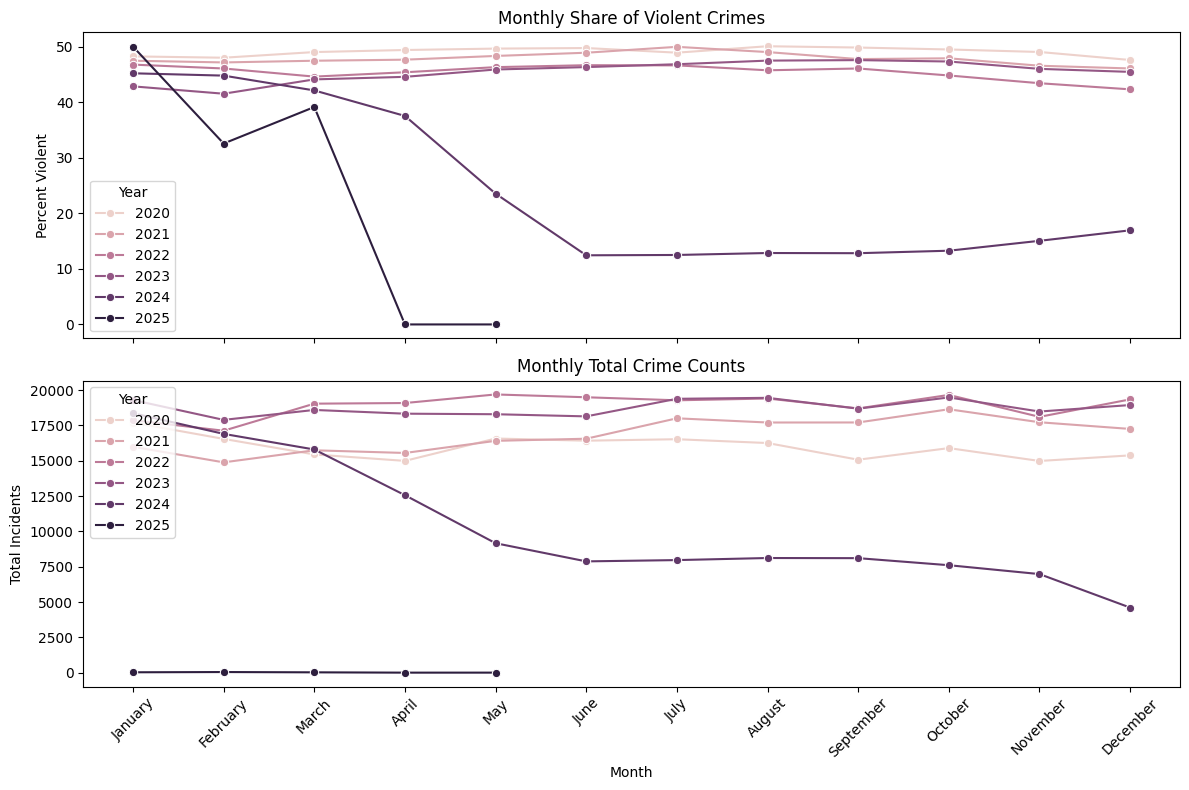

In [20]:
df["Occurred_Year"] = df["Date_Occurred_dt"].dt.year
df["Occurred_Month"] = df["Date_Occurred_dt"].dt.month

# Monthly violent crime counts
monthly_counts = (
    df.groupby(["Occurred_Year", "Occurred_Month"])
      .agg(Total_Incidents=("Crime_Code_Desc", "count"),
           Violent_Incidents=("Is_Violent", "sum"))
      .reset_index()
)

monthly_counts["Violent_Pct"] = (monthly_counts["Violent_Incidents"] / monthly_counts["Total_Incidents"]) * 100

# Pivot for plotting
monthly_counts["Month_Label"] = monthly_counts["Occurred_Month"].apply(lambda x: month_names[x-1])

# Create a figure with 2 plots: 1) monthly violent share, 2) total monthly counts
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Violent crime percentage
sns.lineplot(
    data=monthly_counts,
    x="Month_Label",
    y="Violent_Pct",
    hue="Occurred_Year",
    marker="o",
    ax=axes[0]
)
axes[0].set_title("Monthly Share of Violent Crimes")
axes[0].set_ylabel("Percent Violent")
axes[0].legend(title="Year")

# Plot 2: Total monthly incidents
sns.lineplot(
    data=monthly_counts,
    x="Month_Label",
    y="Total_Incidents",
    hue="Occurred_Year",
    marker="o",
    ax=axes[1]
)
axes[1].set_title("Monthly Total Crime Counts")
axes[1].set_ylabel("Total Incidents")
axes[1].set_xlabel("Month")
axes[1].legend(title="Year", loc="upper left")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig.savefig("figure1.png", dpi=300, bbox_inches="tight")

Figure 2:

In [21]:
# Group by year-month
monthly_violent = (
    df[df['Is_Violent']]
    .groupby(df['Date_Occurred_dt'].dt.to_period('M'))
    .size()
    .rename('Violent_Crimes')
)
monthly_violent.index = monthly_violent.index.to_timestamp()

In [22]:
# 3-month rolling average
rolling_avg = monthly_violent.rolling(3, center=True).mean()

# Year-over-year percent change
yoy_change = monthly_violent.pct_change(12) * 100

In [23]:
import os

# Make sure the folder exists
os.makedirs("Results Figures", exist_ok=True)

/tmp/ipykernel_156/1927551573.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


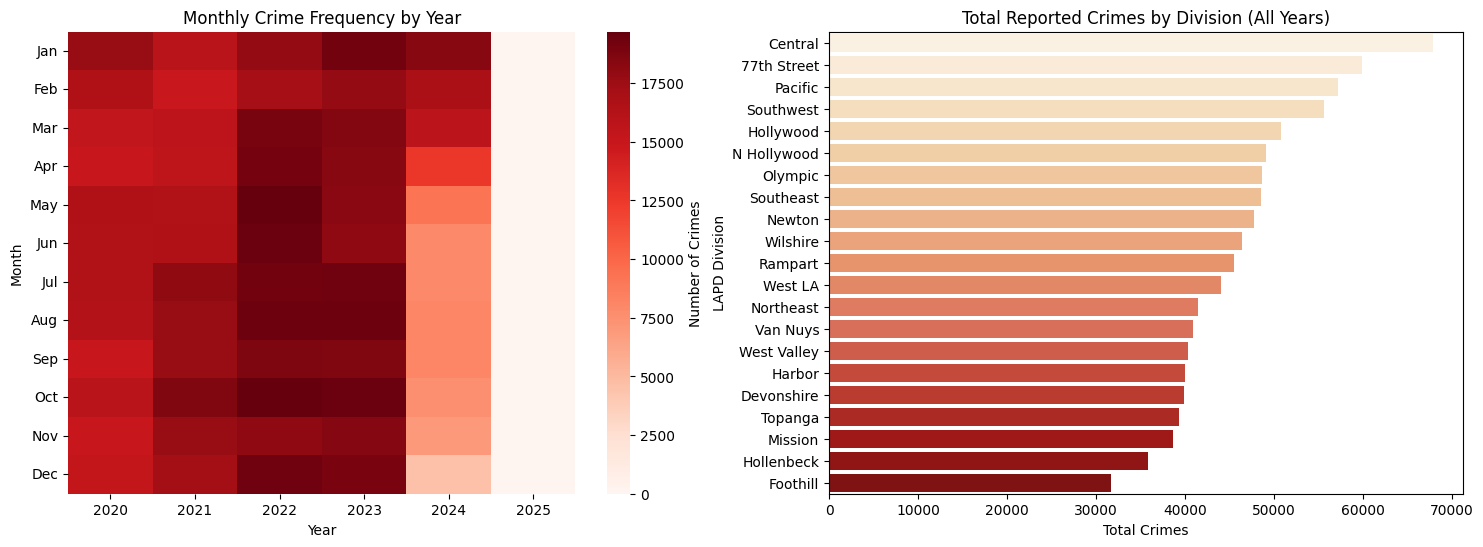

In [24]:
# Heatmap: Monthly crime frequency by year
monthly_counts = (
    df.groupby(['Occurred_Year', 'Occurred_Month'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# Bar chart: Total crimes by division
division_counts = df.groupby('Area_Name').size().sort_values(ascending=False)

# Create side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap
sns.heatmap(
    monthly_counts.T,  # transpose to have months on y-axis
    cmap="Reds",
    ax=axes[0],
    cbar_kws={'label': 'Number of Crimes'}
)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Month")
axes[0].set_title("Monthly Crime Frequency by Year")
axes[0].set_yticklabels([
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], rotation=0)

# Bar chart
sns.barplot(
    x=division_counts.values,
    y=division_counts.index,
    palette="OrRd",
    ax=axes[1]
)
axes[1].set_xlabel("Total Crimes")
axes[1].set_ylabel("LAPD Division")
axes[1].set_title("Total Reported Crimes by Division (All Years)")


plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0c4bf00e-decb-40b9-aec2-e6b1b5357766' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>